# GGS416 Satellite Image Analysis - Week 5

In this tutorial we are going to cover an object detection and extraction example.

The learning outcomes will be:
- Introductory object detection in satellite imagery.
- Extraction of identified objects.
- Cleaning of identified objects. 

Let's first import and inspect an image we will use for this tutorial. 

The location is the north earthern part of Peru at the very source of the Amazon river. 

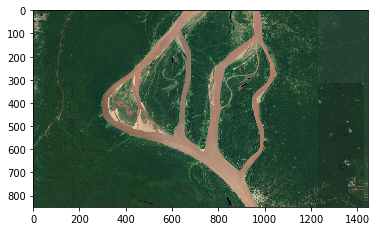

In [3]:
import os
import rasterio
from rasterio.plot import show
from rasterio.features import shapes
import numpy as np
import matplotlib.pyplot as plt

# Open our image as a rasterio object
my_image = rasterio.open('images/riverImage2.tif')

# Plot our image for inspection
# This is plotting the image using the raster coordinates
# Thus, we have ~800 rows and ~1400 columns
show(my_image.read())

We can plot using the real geographic coordinates, via the `show()` function using the argument `transform`. 

See here for more on plotting via `rasterio`: https://rasterio.readthedocs.io/en/latest/topics/plotting.html

To confirm the Coordinate Reference System (CRS) in use, we can print the CRS from the `rasterio` object metadata. 

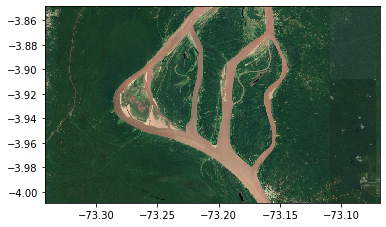

EPSG:4326


In [4]:
show(my_image.read(), transform=my_image.transform)
print(my_image.crs)

Now we have a working image, we can parse out our multiband layers, as we have carried out in many of our previous tutorials. 

The band order is red, green and then blue, as follows:

In [5]:
red = my_image.read(1)
green = my_image.read(2)
blue = my_image.read(3)
red

array([[ 70, 143, 182, ...,  39,  38,  36],
       [ 65, 129, 165, ...,  40,  37,  34],
       [ 67, 115, 151, ...,  40,  35,  41],
       ...,
       [ 34,  34,  35, ...,  37,  35,  34],
       [ 27,  27,  30, ...,  37,  34,  32],
       [ 29,  27,  27, ...,  35,  33,  32]], dtype=uint8)

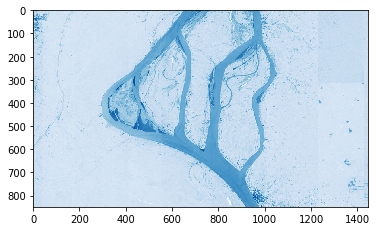

In [6]:
# Plot the blue band
show(blue, cmap='Blues')

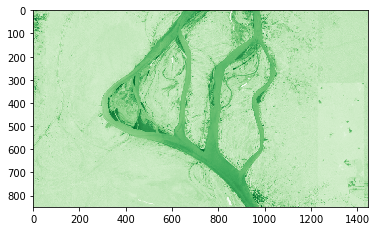

In [7]:
# Plot the green band
show(green, cmap='Greens')

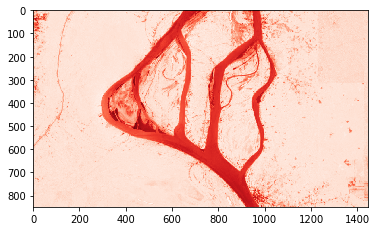

In [8]:
# Plot the red band
show(red, cmap='Reds')

Next, we need to convert these bands to floats:

In [9]:
#change data type
red = np.float32(red)
green = np.float32(green)
blue = np.float32(blue)
red

array([[ 70., 143., 182., ...,  39.,  38.,  36.],
       [ 65., 129., 165., ...,  40.,  37.,  34.],
       [ 67., 115., 151., ...,  40.,  35.,  41.],
       ...,
       [ 34.,  34.,  35., ...,  37.,  35.,  34.],
       [ 27.,  27.,  30., ...,  37.,  34.,  32.],
       [ 29.,  27.,  27., ...,  35.,  33.,  32.]], dtype=float32)

Now we can create our index. 

For any area where the red color value is higher than the green color value, we will allocate the value 1. 

If you manually inspect the color plots for the bands above, you will see that the red values are largest over the river areas.  

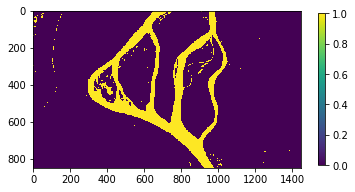

In [10]:
# Create a new empty numpy array of zeros.#
water_index = np.zeros(blue.shape)

# Now let's allocate values to our water index
# Where red is larger than green, we will apply 1
water_index[(red > green)] = 1

plt.imshow(water_index)
plt.colorbar(shrink=0.7)

Whereas the previous example is relatively simple (e.g., red > green), we could introduce more complicated logic.

For example, here we apply 1 to those pixes where: 
- red > green 
- red > 70 
- red < 120

You should compare the previous graphic and the one below to see the differences. 

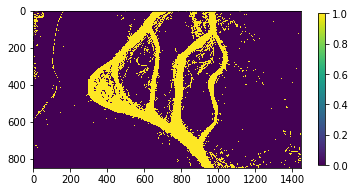

In [11]:
# Create a new empty numpy array of zeros.#
water_index = np.zeros(blue.shape)

# Now let's allocate values to our water index
# Where red is larger than green, we will apply 1
water_index[(red > green) |  (red > 70) & (red < 120)] = 1
plt.imshow(water_index)
plt.colorbar(shrink=.7)

We now want to convert our `numpy` water index variable into an actual set of geojson shapes.

For this to work, we will need to convert the existing **float64** to a data type the function accepts, such as **float32**.

Then we can use the `rasterio.features.shapes()` function to convert to geojson polygon shapes. 

In [12]:
# Convert from float64 to float32 first
water_index = water_index.astype('float32')

# Now convert the numpy array to geojson
my_shapes = shapes(water_index)

# Let's inspect the first geojson
# When we reach the break command the loop ceases
# Thus, only the first is printed.
for my_shape in my_shapes:
    print(my_shape)
    break 

({'type': 'Polygon', 'coordinates': [[(2.0, 0.0), (2.0, 1.0), (3.0, 1.0), (3.0, 2.0), (6.0, 2.0), (6.0, 1.0), (7.0, 1.0), (8.0, 1.0), (8.0, 0.0), (2.0, 0.0)]]}, 1.0)


Before these shapes are written into our working directory, it is important to make a new folder (`shapes`). 

This way we can keep our directories clean and tidy. 

We can utilize some logic from our Python operating system package `os`, via the function `os.path.exists()`.

This checks if the existing folder exists or not. And if it doesn't, we can use `os.mkdir()` to actually create it. 

In [13]:
# Define our desired folder name
output_folder = 'shapes'

# Now let's check if the path exists
if not os.path.exists(output_folder):
    os.mkdir(output_folder) # If not, then make the directory

We will need to transform our raster coordinates into geographic cordinates, so let's define a function to help with that. 

In [14]:
def transform_coordinates(pair):
    """
    This function takes a pair of raster coordinates 
    and returns the geographic coordinates. 
    
    """
    geographic_coordinates = my_image.xy(pair[1],pair[0])
    
    return geographic_coordinates


In the cell below, we can take a look at what our function actually does. 

The cell carried out the following steps:
- Starts looping over the shapes we extracted.
- Prints the coordinates of the first shape.
- Converts the raster coordinate to geographic coordinates.
- Prints the geographic coordinates for the first shape. 
- Ceases the loop when the break command is reached. 

In [15]:
# Loop over the shapes we created
for river in my_shapes:
    
    # Print the original coordinates for the raster
    print('These are the original raster coordinates:')
    print(river[0]['coordinates'])
    print('--')
    
    # Transform the coordinate into geographic ones
    # This is a list comprehension which feeds each pair of coordinate to our function
    coordinates = [transform_coordinates(pair) for pair in river[0]['coordinates'][0]]
    
    # Now we can inspect the difference after the transformation
    print('Whereas these are the transformed geographic coordinates:')
    print(coordinates)
    
    break

These are the original raster coordinates:
[[(10.0, 0.0), (10.0, 4.0), (14.0, 4.0), (14.0, 2.0), (12.0, 2.0), (12.0, 3.0), (11.0, 3.0), (11.0, 2.0), (12.0, 2.0), (12.0, 1.0), (11.0, 1.0), (11.0, 0.0), (10.0, 0.0)]]
--
Whereas these are the transformed geographic coordinates:
[(-73.33984923771577, -3.848812947665282), (-73.33984923771577, -3.8495682266307036), (-73.33909395875034, -3.8495682266307036), (-73.33909395875034, -3.849190587147993), (-73.33947159823305, -3.849190587147993), (-73.33947159823305, -3.8493794068893483), (-73.33966041797441, -3.8493794068893483), (-73.33966041797441, -3.849190587147993), (-73.33947159823305, -3.849190587147993), (-73.33947159823305, -3.8490017674066372), (-73.33966041797441, -3.8490017674066372), (-73.33966041797441, -3.848812947665282), (-73.33984923771577, -3.848812947665282)]


Next, we can actually use this function we've created:

- 

In [16]:
import sys
!conda install --yes --prefix {sys.prefix} geopandas

Solving environment: ...working... done

# All requested packages already installed.



In [17]:
# Create an empty dataframe 
output = []

# Iterate over our shapes
for river_shape in my_shapes:

    # Index into our shape to get the coordinates
    # This indexing means we access:
    # - The first list in `river_shape` via [0]
    # - The coordinates values in the dictionary via ['coordinates']
    # - The first list in `coordinates` via [0]
    coords = river_shape[0]['coordinates'][0]

    # Transform the raster coordinates into geographic coordinates
    geographic_coords = [transform_coordinates(pair) for pair in coords]

    # Specify a geojson with our transformed coordinates
    output.append({
        'geometry' : {
            'type':'LineString',
            'coordinates': geographic_coords
            },
        'properties': {},
    }) 
        
print('Output contains {} shapes'.format(len(output)))

Output contains 4479 shapes


Now we can write the data to file using `geopandas`:

In [18]:
import geopandas

data_to_write = geopandas.GeoDataFrame.from_features(output, crs='epsg:4326')

data_to_write.to_file('shapes/river_shape.shp')

## Task 1

- Inspect the resulting shapefile that we extracted. 
- Think critically about the output. 
- Consider of a way to try reduce the quantity of shapes we are writing. Ideally, we just want the main river outline. 
- Hint: Try implement if statement logic in the main loop where we iterate over `my_shapes`, convert the coordinates, and append as geojson data structures. We essentially want to exclude those small shapes with few coordinates.


## Task 2

- Download an image of your choice which contains a body of water. 
- Write a new jupter notebook which:
    - Reads in the image.
    - Extracts areas of water.
    - Writes the water feature shapes ready for submission.
